# Lesson 5a: Recurrent Neural Networks: Sequence Prediction

**This week's homework has two different parts: rnn_sine and rnn_divisibility. Be sure to do both!**

Each part focuses on a different type of Recurrent Neural Network architecture: prediction or classification

* 5a) **rnn_sine** (this file): Prediction of the next time point given the previous time history
* 5b) **rnn_divisibility**: Categorization of an input string

In this homework, you will create a *synthetic* dataset based on some simple mathematical functions. Then, you will design an RNN architecture that can read several function values in a row (*e.g.*, the values of the function at time points 0, 1, 2, 3, 4) and predict the next value (*e.g.*, the value of the function at time point 5).

# Setup
## Imports

In [56]:
%matplotlib inline

import tensorflow as tf

from tensorflow.python.keras import backend as K
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.regularizers import l1_l2
import math
import numpy as np
import matplotlib.pyplot as plt


In [57]:
print(tf.version.VERSION)
tf.executing_eagerly()

2.17.0


True

## Configure Tensorflow to be less aggressive about RAM utilization when it starts up

In [58]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1  # Start with 10% of the GPU RAM
config.gpu_options.allow_growth = True                    # Dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)                                         # Set this TensorFlow session as the default session for Keras

# Settings

In [59]:
NUM_LSTM_NODES = 15
NUM_EPOCHS = 10


#Set up params for dataset.
NUM_FREQS = 2      # Number of sine waves to superimpose
SR = 200           # Digital sampling rate
MAX_FREQ = SR / 2  # Nyquist frequency
two_pi = 2 * math.pi

MAX_FREQ /= 4  # calm the frequencies down a little.

MAX_X_DATA = 5     # Set x-range from 0 to MAX_X_DATA

TRAIN_TEST_SPLIT = 0.7  # Percentage of data in training set

# Use this to try on random sine waves if you'd like.
RANDOMIZE_WAVES = False
if RANDOMIZE_WAVES:
    np.random.seed(42)
    freqs = np.random.rand(NUM_FREQS) * MAX_FREQ
    amplitudes = np.random.rand(NUM_FREQS)
    phases = np.random.rand(NUM_FREQS) * two_pi
    waves = list(zip(freqs, amplitudes, phases))
else:
    # Or just use fixed frequencies etc, to make it easier:
    waves = [(20, .5, 0), (3, .3, 3)]  # Each element is (freq, amplitude, phase)
waves

[(20, 0.5, 0), (3, 0.3, 3)]

In [60]:
# Make the sine wave data.
data = []
t_list = [float(i)/SR for i in range(SR * MAX_X_DATA)]
for t in t_list:
    total = 0
    for freq, A, phase in waves:
        total += A * np.sin(phase + t * freq * two_pi)
    data.append(total)

# normalize
max_data = abs(np.max(data))
data /= max_data

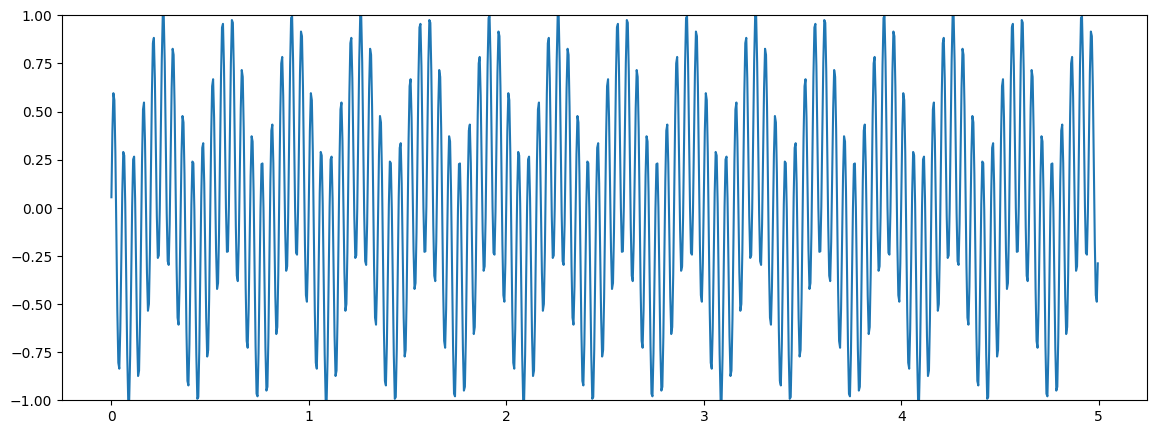

In [61]:
plt.figure(figsize=(14,5))
plt.ylim(-1,1)
plt.plot(t_list, data)
plt.show()

In [62]:
# Make input/ouput pairs: match datapoint (N) to each datapoint (N+1)
# data_pairs should be a list of data points like [(data_1, data_2), (data_2, data_3),...]
data_pairs = []
for i in range(len(data) - 1):
    data_pairs.append((data[i], data[i+1]))

In [63]:
split_idx = int(len(data_pairs)*TRAIN_TEST_SPLIT )
train = data_pairs[:split_idx]
test = data_pairs[split_idx:]

train_x = np.array([x[0] for x in train])
train_y = np.array([x[1] for x in train])
train_x = np.reshape(train_x, (len(train_x), 1, 1))  # batch, #prev_context, #input nodes
train_y = np.reshape(train_y, (len(train_y), 1))     # batch, #prev_context, #output nodes

test_x = np.array([x[0] for x in test])
test_y = np.array([x[1] for x in test])
test_x = np.reshape(test_x, (len(test_x), 1, 1))  # batch, #prev_context, #input nodes
test_y = np.reshape(test_y, (len(test_y), 1))     # batch, #prev_context, #output nodes

In [64]:
print(train_x.shape)
print(train_y.shape)

(699, 1, 1)
(699, 1)


In [65]:
# Build LSTM model.

# Modified to improve performance.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Input(batch_shape=(1,1,1), dtype='float32', name='INPUT'))
model.add(LSTM(NUM_LSTM_NODES, stateful=True, return_sequences=True, name='LSTM_1'))
model.add(Dropout(0.2))
model.add(LSTM(NUM_LSTM_NODES // 2, stateful=True, name='LSTM_2'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), run_eagerly=True, metrics=['mse'])
early_stopping = EarlyStopping(monitor='loss', patience=5)


In [66]:
# fit model
for i in range(NUM_EPOCHS):
  print("Epoch %d" % i)
  model.fit(train_x, train_y, batch_size=1, epochs=1, shuffle=False, verbose=1, callbacks=[early_stopping])
  model.get_layer(name="LSTM_1").reset_states()
  model.get_layer(name="LSTM_2").reset_states()


Epoch 0
699/699 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - loss: 0.2862 - mse: 0.2862
Epoch 1
699/699 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - loss: 0.1623 - mse: 0.1623
Epoch 2
699/699 ━━━━━━━━━━━━━━━━━━━━ 74s 105ms/step - loss: 0.0544 - mse: 0.0544
Epoch 3
699/699 ━━━━━━━━━━━━━━━━━━━━ 72s 103ms/step - loss: 0.0418 - mse: 0.0418
Epoch 4
699/699 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - loss: 0.0377 - mse: 0.0377
Epoch 5
699/699 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - loss: 0.0300 - mse: 0.0300
Epoch 6
699/699 ━━━━━━━━━━━━━━━━━━━━ 74s 106ms/step - loss: 0.0280 - mse: 0.0280
Epoch 7
699/699 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - loss: 0.0227 - mse: 0.0227
Epoch 8
699/699 ━━━━━━━━━━━━━━━━━━━━ 73s 104ms/step - loss: 0.0208 - mse: 0.0208
Epoch 9
699/699 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - loss: 0.0191 - mse: 0.0191


In [67]:
# Evaluate accuracy
scores = model.evaluate(test_x, test_y, batch_size=1, verbose=0)
model.get_layer(name="LSTM_1").reset_states()
model.get_layer(name="LSTM_2").reset_states()
#print("Model Accuracy: %.2f%%" % (scores*100)) # Not an accuracy prediction model

In [68]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (1, 1, 15)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (1, 1, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_2 (LSTM)                        │ (1, 7)                      │             644 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (1, 7)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 10)                     │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 1)                      │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,267 (20.58 KB)

 Trainable params: 1,755 (6.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,512 (13.72 KB)

## Make predictions with the model

In [69]:
result = []
for i in range(len(test_x)):
    prediction = model.predict(test_x[i].reshape(1,1,1), verbose=0)
    result.append([prediction, test_y[i]])
model.get_layer(name="LSTM_1").reset_states()
model.get_layer(name="LSTM_2").reset_states() # model.reset_states() # Do this after giving an input sequence, to clear out hidden states.

In [70]:
predictions = [[x[0][0][0], x[1][0]] for x in result]

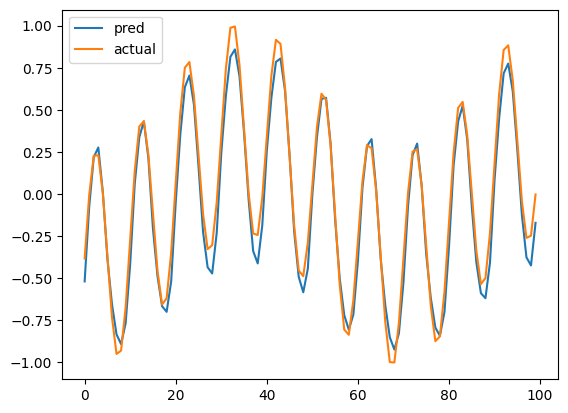

In [71]:
plt.plot(predictions[50:150])
plt.legend(('pred', 'actual'))
plt.show()

In [72]:
errors = [abs(x[1] - x[0]) for x in predictions]

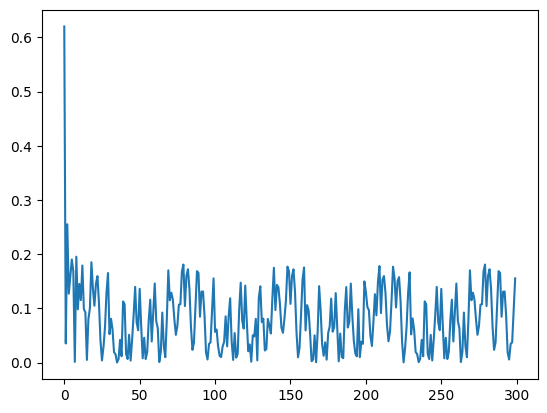

In [73]:
plt.plot(errors)
plt.show()

## Question 1: Discuss the results. How accurate was the model? What did you do to improve its accuracy? What problems did you run into?

1. The model was pretty accurate, I think without being overfit. Error rate dropped but seems to follow a normal pattern with deviations. I improved the accuracy by adding a second LSTM layer and several dropout layers, and set an early stop on loss (MSE) to try and avoid overfitting. Most of the problems I ran into were converting to Keras 2.17 and just reading the documentation to make sure I had the correct API calls for resetting the LSTM layers. I also adjusted the learning rate to be faster to improve the model -- too low of a value caused lots of underfitting:
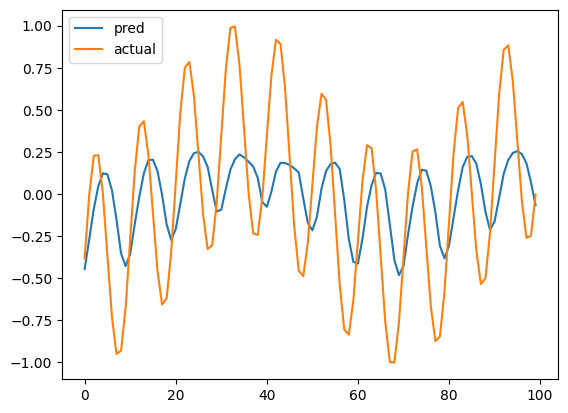


## Question 2: What problems did you run into, if any?

2. Mostly converting from Keras 1.X to 2.X, and adjusting some areas of the model. I got a good tour of the Keras suite by doing so. I originally had a pretty underfit model as mentioned. I also do not know how to best evaluate LSTM predictions - total MSE?

In [ ]:
%%shell

jupyter nbconvert --to html /content/Lab05b.ipynb